In this notebook we explore more about eye tracking data analysis

In [113]:
# Derived from:
#     https://www.axonlab.org/hcph-sops/data-management/eyetrack-qc
# Load the autoreload extension
%load_ext autoreload
# Set autoreload to update the modules every time before executing a new line of code
%autoreload 2

%matplotlib inline
from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et

from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
from write_bids_yiwei import EyeTrackingRun, write_bids, write_bids_from_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 1: Inspecting Eye-Tracking Data

In this step, we’ll begin by parsing the metadata of our eye-tracking data. This will help us understand the structure of the data, including the recording parameters, subject details, and any relevant events or labels. Parsing the metadata provides insight into the conditions and settings during data collection, which is essential for accurate analysis.


In [114]:
# Specify the subject and modality you want to inspect

subject_idx = 1
T_idx = 1

if T_idx == 1:
    mode = 'T1'
else:
    mode = 'T2'


BIDS_PATH = Path("./data/")  # file within a subdirectory
FILE_NAME = f"sub00{subject_idx}_T{T_idx}"    
    
# session = "001" #can be a string to be defined when required
tsv_name = f"{FILE_NAME}.tsv.gz"

recording_file = BIDS_PATH / tsv_name
print(f'recording_file: {recording_file}')

recording = pd.read_csv(
    recording_file,
#     sep=r"\s+",
    sep="\t",
    na_values="n/a",
)

recording_file: data/sub001_T1.tsv.gz


This command shows the first few rows of our eye-tracking dataset, 
helping us understand the organization, key columns, and the format of the data. 
This step is useful to verify that the data loaded correctly and to identify any initial patterns or anomalies.

In [115]:
recording.head()

,Unnamed: 0,eye1_x_coordinate,eye1_y_coordinate,eye1_pupil_size,eye1_pupil_x_coordinate,eye1_pupil_y_coordinate,eye1_href_x_coordinate,eye1_href_y_coordinate,fast_raw_x_velocity,screen_ppdeg_x_coordinate,screen_ppdeg_y_coordinate,timestamp,eye1_fixation,eye1_saccade,eye1_blink
0,0,599.799988,440.299988,2721.0,1126.0,-4793.0,1972.0,1384.0,4.591214e-41,27.1,26.9,1084634,0,0,0
1,1,600.000000,441.299988,2718.0,1129.0,-4782.0,1974.0,1394.0,4.591214e-41,27.1,26.9,1084635,0,0,0
2,2,600.700012,442.399994,2716.0,1138.0,-4769.0,1981.0,1405.0,4.591214e-41,27.1,26.9,1084636,0,0,0
3,3,601.400024,442.700012,2709.0,1147.0,-4766.0,1988.0,1408.0,4.591214e-41,27.1,26.9,1084637,0,0,0
4,4,601.799988,443.000000,2704.0,1152.0,-4762.0,1991.0,1411.0,4.591214e-41,27.1,26.9,1084638,0,0,0


In [116]:
print(f'recording length: {len(recording)}')

recording length: 754932


### Step 2: Understanding Metadata

The metadata provides crucial information about the setup and parameters used during eye-tracking data collection. By examining the metadata, we can gain insights into the recording conditions, data quality, and calibration settings.


In [117]:
metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())

metadata

{'AverageCalibrationError': [0.5],
 'CalibrationCount': 1,
 'CalibrationLog': [[1047679,
   '>>>>>>> CALIBRATION (HV5,P-CR) FOR RIGHT: <<<<<<<<<'],
  [1047679, 'Calibration points:'],
  [1047680, '-10.3, -50.9         0,      0'],
  [1047680, '-8.9, -71.9         0,  -2457'],
  [1047680, '-9.3, -29.2         0,   2457'],
  [1047680, '-41.2, -50.5     -3474,      0'],
  [1047680, '24.2, -49.8      3474,      0'],
  [1047680, 'eye check box: (L,R,T,B)\n\t  -48    31   -76   -25'],
  [1047680, 'href cal range: (L,R,T,B)\n\t-5211  5211 -3686  3686'],
  [1047680,
   'Cal coeff:(X=a+bx+cy+dxx+eyy,Y=f+gx+goaly+ixx+jyy)\n   5.882e-05  107.02  1.2434 -0.18295 -0.27969 \n   4.4115e-05 -0.84952  115.02 -0.085003 -0.090966'],
  [1047680, 'Prenormalize: offx, offy = -10.326 -50.929'],
  [1047680, 'Gains: cx:102.441 lx:116.794 rx:88.586'],
  [1047680, 'Gains: cy:109.181 ty:118.022 by:110.039'],
  [1047680, 'Resolution (upd) at screen center: X=2.6, Y=2.4'],
  [1047680, 'Gain Change Proportion: X: 0.

For instance:
- **RecordedEye**: This specifies which eye was tracked. Here, the data corresponds to the right eye.
- **SamplingFrequency**: The sampling rate is 1000 Hz (1 kHz), meaning the data captures 1000 samples per second.
- **CalibrationDetails**: We can see the calibration method used (`HV5`), calibration quality (`GOOD`), and errors.

Understanding these parameters helps us ensure data reliability and assess the quality of eye-tracking measurements before analysis.

In [118]:
# Prepare the time axis based on the sampling frequency

t_axis = (
    recording.timestamp.values - recording.timestamp[0]
) / metadata["SamplingFrequency"]
print(f"The end of the timestamp: {t_axis[-1]}")

The end of the timestamp: 754.931


In [119]:
# Change the naming to make it more readable
recording = recording.rename(
        columns={
            f"eye1_pupil_size": f"pupil_size",
            f"eye1_fixation": f"fixation",
            f"eye1_saccade": f"saccade",
            f"eye1_blink": f"blink",
            f"eye1_x_coordinate": f"x_coordinate", 
            f"eye1_y_coordinate": f"y_coordinate"         
        }
    )

metadata["Columns"] = recording.columns.tolist()

In [120]:
metadata["Columns"]

['Unnamed: 0',
 'x_coordinate',
 'y_coordinate',
 'pupil_size',
 'eye1_pupil_x_coordinate',
 'eye1_pupil_y_coordinate',
 'eye1_href_x_coordinate',
 'eye1_href_y_coordinate',
 'fast_raw_x_velocity',
 'screen_ppdeg_x_coordinate',
 'screen_ppdeg_y_coordinate',
 'timestamp',
 'fixation',
 'saccade',
 'blink']

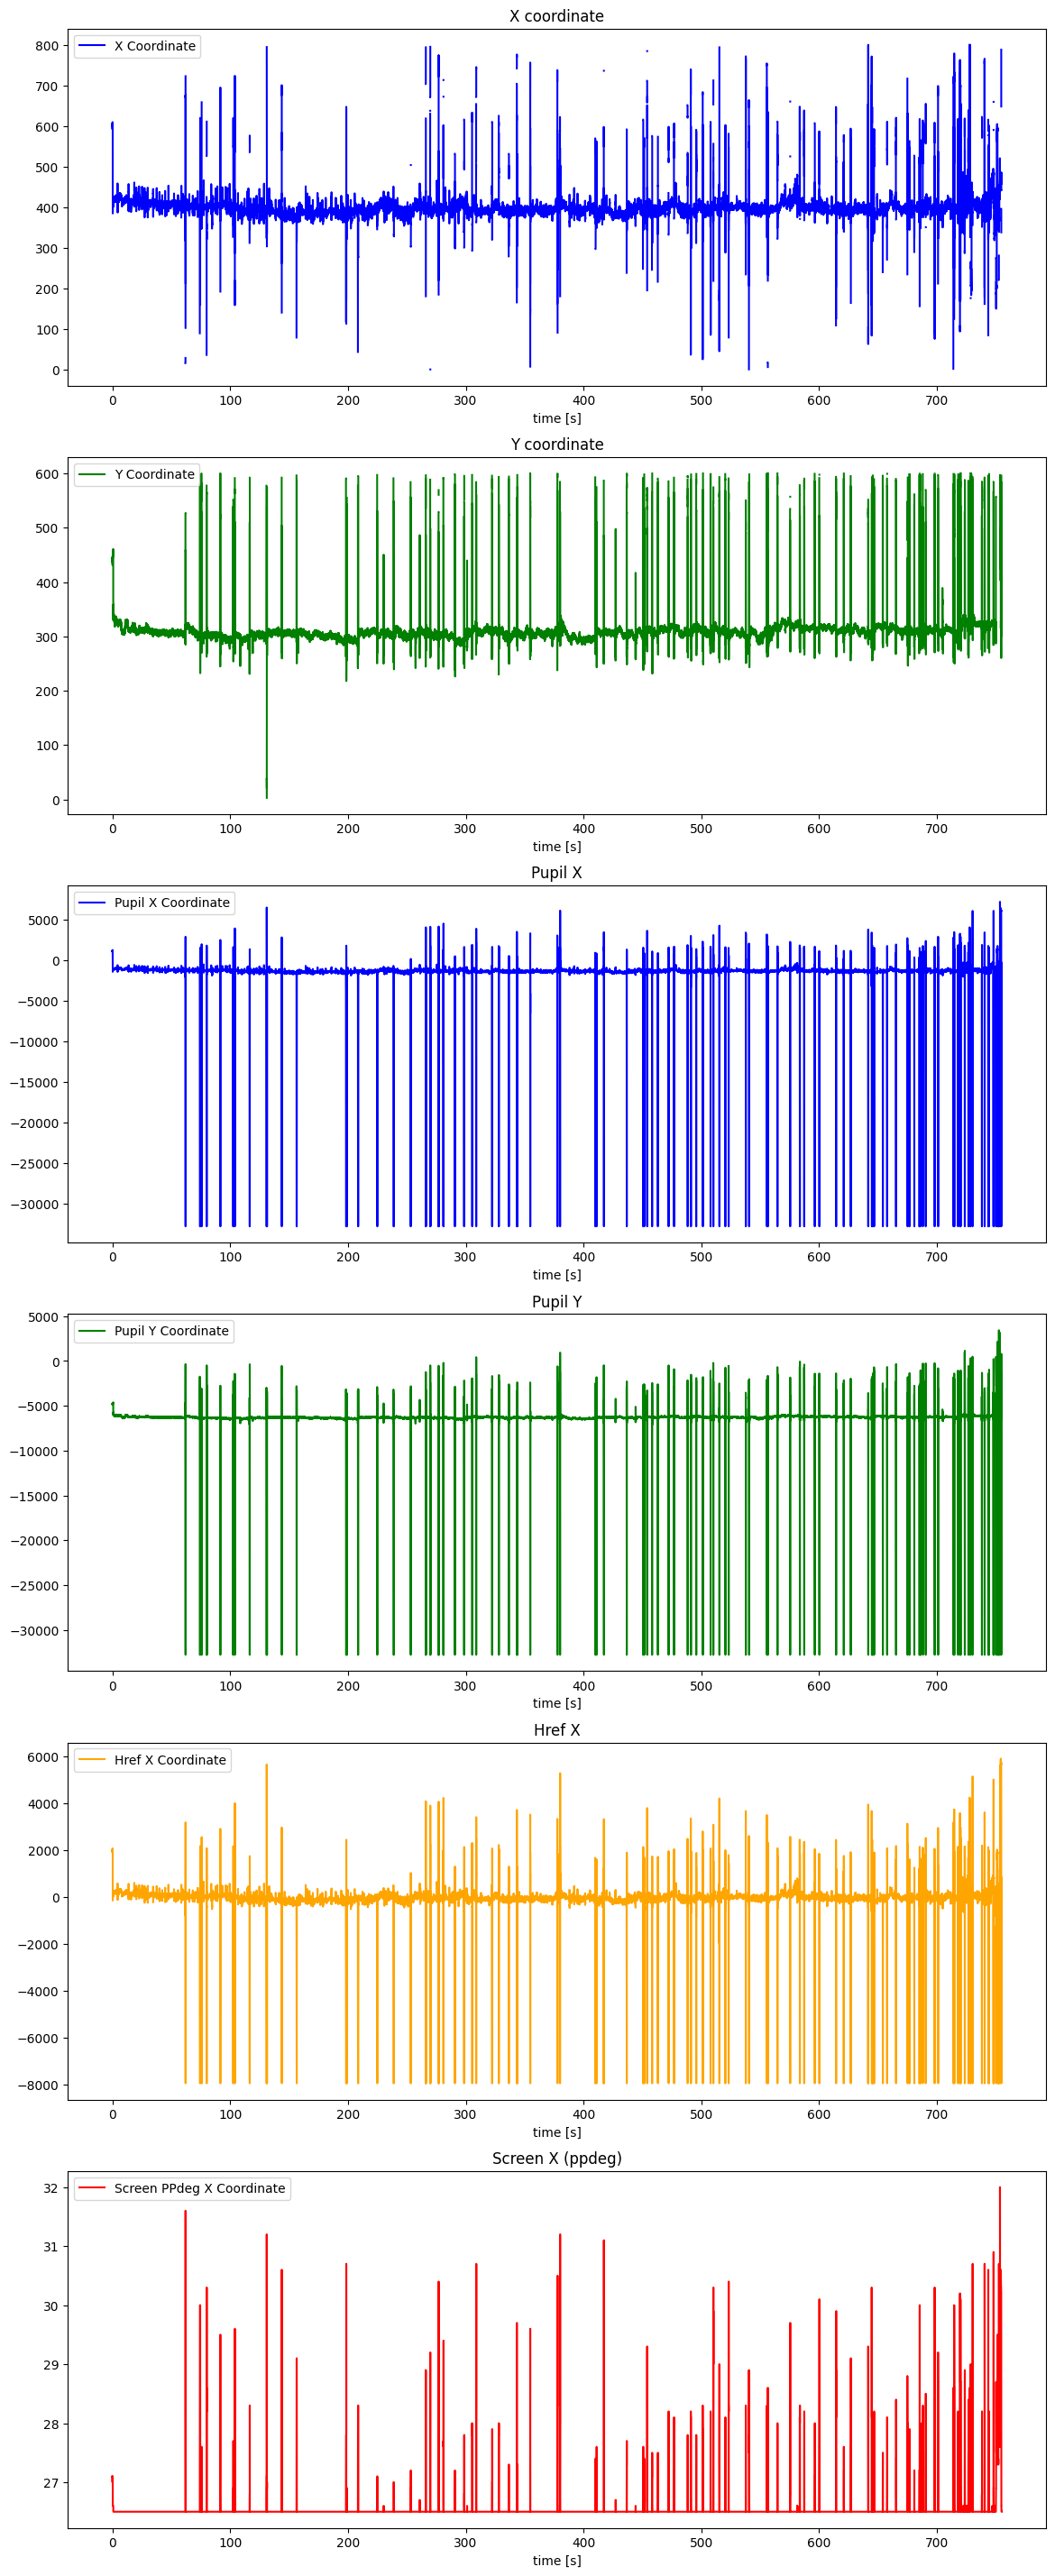

In [121]:
check_all = True
if check_all:
    fig,axes = plt.subplots(6, 1, figsize=(14, 36), sharex=False)

     # Plot x coordinate
    axes[0].plot(t_axis, recording["x_coordinate"].values, label='X Coordinate', color='blue')
    axes[0].set_title("X coordinate")
    axes[0].legend()
    axes[0].set_xlabel("time [s]")
    
    # Plot y coordinate
    axes[1].plot(t_axis, recording["y_coordinate"].values, label='Y Coordinate', color='green')
    axes[1].set_title("Y coordinate")
    axes[1].legend()
    axes[1].set_xlabel("time [s]")
    
    # Plot pupil x coordinate
    axes[2].plot(t_axis, recording["eye1_pupil_x_coordinate"].values, label='Pupil X Coordinate', color='blue')
    axes[2].set_title("Pupil X")
    axes[2].legend()
    axes[2].set_xlabel("time [s]")
    
    # Plot pupil y coordinate
    axes[3].plot(t_axis, recording["eye1_pupil_y_coordinate"].values, label='Pupil Y Coordinate', color='green')
    axes[3].set_title("Pupil Y")
    axes[3].legend()
    axes[3].set_xlabel("time [s]")
    
    # Plot href x coordinate
    axes[4].plot(t_axis, recording["eye1_href_x_coordinate"].values, label='Href X Coordinate', color='orange')
    axes[4].set_title("Href X")
    axes[4].legend()
    axes[4].set_xlabel("time [s]")
    
    # Plot screen ppdeg x coordinate
    axes[5].plot(t_axis, recording["screen_ppdeg_x_coordinate"].values, label='Screen PPdeg X Coordinate', color='red')
    axes[5].set_title("Screen X (ppdeg)")
    axes[5].legend()
    axes[5].set_xlabel("time [s]")
    
    plt.ylabel(" ");

    

Have a basic idea about what the signal looks like and what is the scale of the values.

Check the pupil area

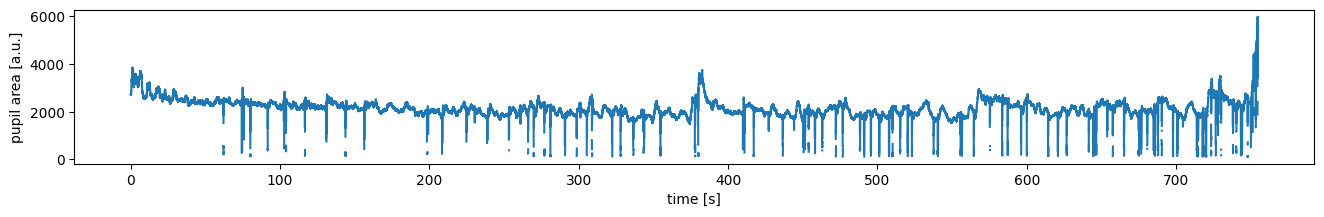

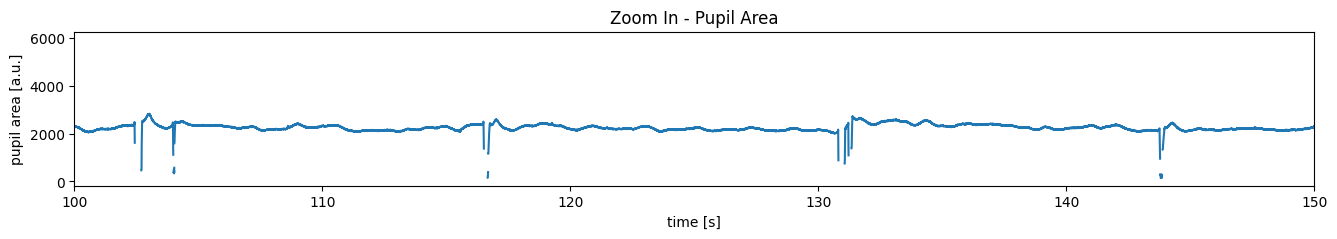

In [122]:
check_pupil = True
if check_pupil:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]");

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )
    plt.title("Zoom In - Pupil Area")
    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    # JB1 (100, 150)
    plt.xlim((100, 150))

Check the eye events:

 - Blink
    
- Saccade
    
- Fixation

Check blinking

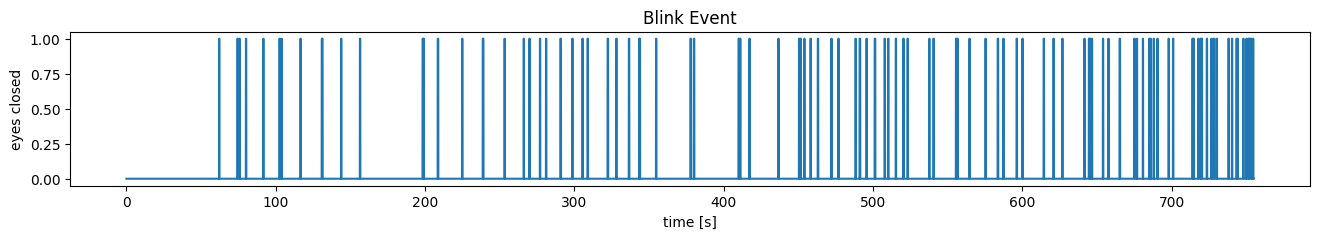

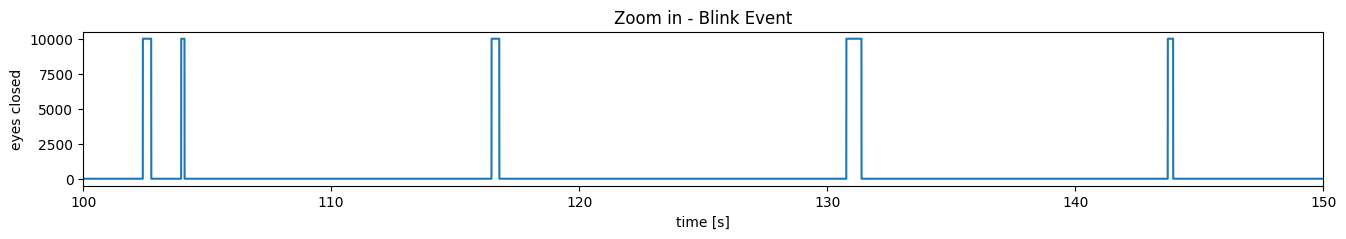

In [123]:
check_blink = True
if check_blink:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["blink"].values,
    )
    plt.title("Blink Event")
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed");

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["blink"].values * 10000,
    )
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed")
    plt.title("Zoom in - Blink Event")
    plt.xlim((100, 150))

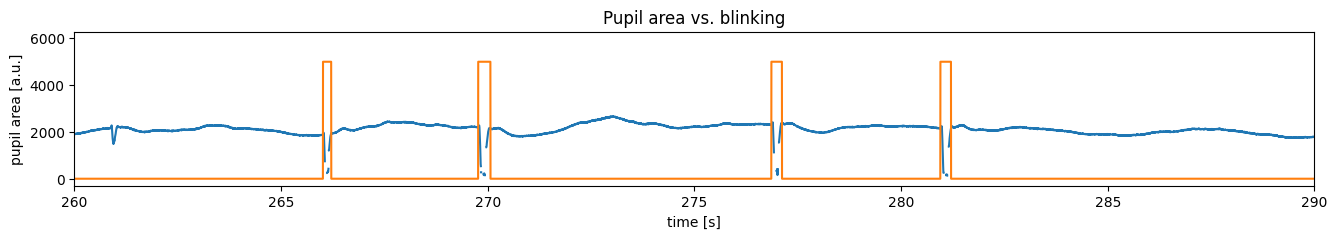

In [124]:
plot_pupil_blink = True
if plot_pupil_blink:
    fig = plt.figure(figsize=(16, 2))

    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.plot(
        t_axis,
        recording["blink"].values * 5000,
    )
    # screen_coor = recording["screen_ppdeg_x_coordinate"].values
    # plt.plot(
    #     t_axis,
    #     (screen_coor-np.min(screen_coor))/(np.max(screen_coor)-np.min(screen_coor)) * 7000
    # )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    plt.xlim((260, 290))
    plt.title('Pupil area vs. blinking')



Check saccading

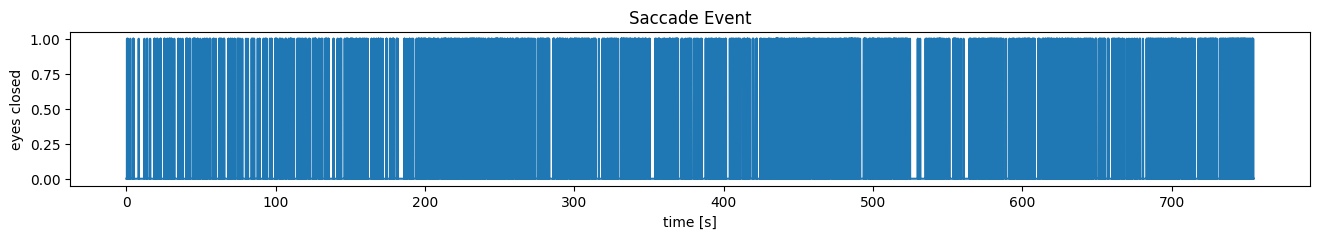

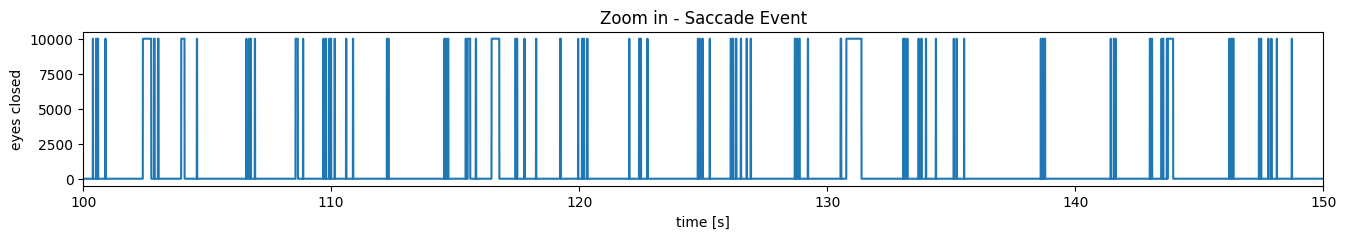

In [125]:
Check_saccading=True
if Check_saccading:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["saccade"].values,
    )
    plt.title("Saccade Event")
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed");

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["saccade"].values * 10000,
    )
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed")
    plt.title("Zoom in - Saccade Event")
    plt.xlim((100, 150))

At this time, since blinking is detected, we cannot get clear pupil area ?


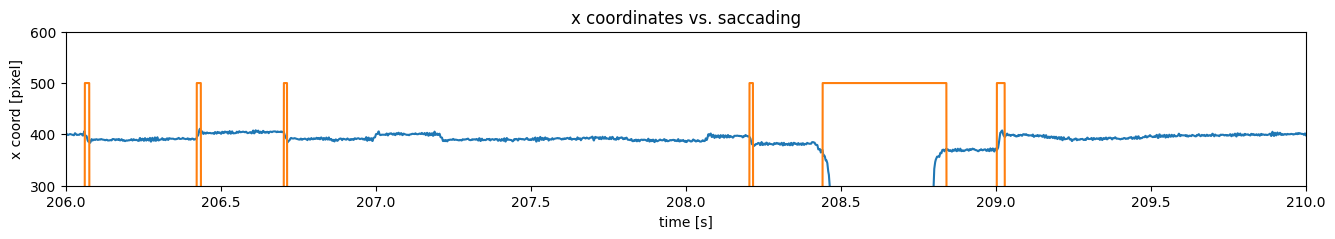

In [126]:
plot_pupil_saccade = True

if plot_pupil_saccade:
    fig = plt.figure(figsize=(16, 2))

    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 500,
    )

    plt.xlabel("time [s]")
    plt.ylabel("x coord [pixel]")
    plt.xlim((206, 210))
    plt.ylim((300, 600))
    plt.title('x coordinates vs. saccading')
    print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

Check fixation

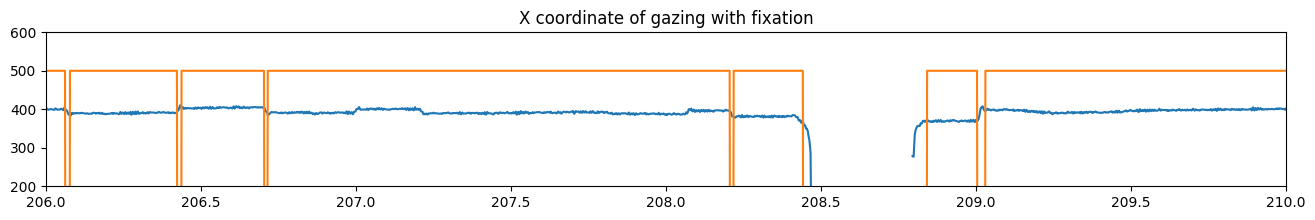

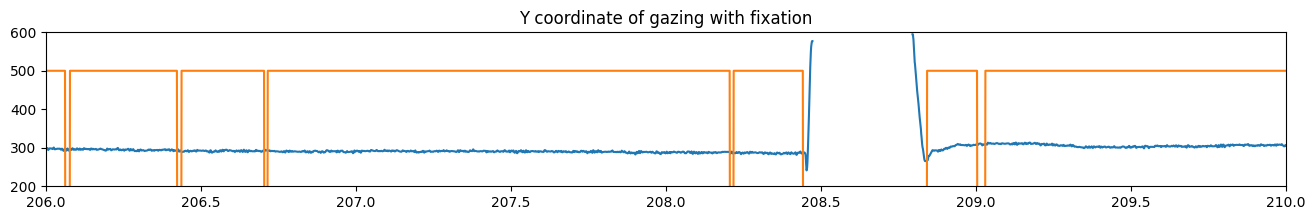

In [127]:
plot_fixation = True
xlim = (206, 210)
ylim = (200, 600)

if plot_fixation:
    # Fixation
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["fixation"].values * 500,
    )
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('X coordinate of gazing with fixation')

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["y_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["fixation"].values * 500,
    )
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('Y coordinate of gazing with fixation')

The analysis did not reveal a strong correlation between x coordinates and saccade or fixation events.

The coordinate sequence is stable during fixation, we should extract the data in the event.

## information

### T1-weighted 

- name psychopy and ET data: JB1

- duration of the protocol: 720sec (12 min)

- Our protocol (p178 6:02 min + 15.03s + 05:57 min)

- differences between the two sequence: 15.03 sec

- ET calibration: 5 points

- LIBRE Voxel size: 0.5mm * 0.5mm * 0.5mm

- VIBE Voxel size: 0.4mm * 0.4mm * 0.4mm

### T2-weighted 

- name psychopy and ET data: JB2

- duration of the protocol: 1105sec (ca. 18 min)

- Our protocol (p178 10:42 min + 7.15s + 07:32 min)

- differences between the two sequence: 

- ET calibration: 5 points

- LIBRE Voxel size: 0.5mm * 0.5mm * 0.5mm

- TSE Voxel size: 0.3mm * 0.3mm * 1.5mm


# Data Cleaning

- Seperate the two phases of sequences
- Extract the X Y coordinates
- Eliminate the blinking and non-fixation area of LIBRE data, and keep the raw data of STANDARD.Because there is no mechanism for the second STANDARD one to correct the eye fixation.
- Design some criteria for cleaning the noise data
    - Visual angle
    - Heat maps
    - Fixation algorithm (literature review)

### Seperate the two phases of sequences

In [128]:
# Duration setting according to the protocol (in sec) not any more
# Duration setting according to the raw data info

if  subject_idx == 1:
    T1_LIBRE = 374.558
    T2_LIBRE = 650.185
elif subject_idx == 2:
    T1_LIBRE = 374.380
    T2_LIBRE = 650.185
elif subject_idx == 3:
    T1_LIBRE = 334.237
    T2_LIBRE = 650.1925 
else:
    T1_LIBRE = 374.565
    T2_LIBRE = 650.1875
    
T1_GAP = 15.03
T1_VIBE = 5*60+57


T2_GAP = 7.15
T2_TSE = 7*60+32

if T_idx == 1:
    print(f"The length of T1_LIBRE Subject{subject_idx} should be: {T1_LIBRE}")
else:
    print(f"The length of T2_LIBRE Subject{subject_idx} should be: {T2_LIBRE}")
# length_T1 = metadata['SamplingFrequency']*(T1_LIBRE+T1_GAP+T1_VIBE)
# print(f"The length of T1 should be: {length_T1}")
# length_T2 = metadata['SamplingFrequency']*(T2_LIBRE+T2_GAP+T2_TSE)
# print(f"The length of T2 should be: {length_T2}")

The length of T1_LIBRE Subject1 should be: 374.558


In [129]:
# -----------------------------
reset_index_bool = False
eliminate_all_nan = False
eliminate_first_nan = False
# -----------------------------

size = (
    metadata["ScreenAOIDefinition"][1][1],
    metadata["ScreenAOIDefinition"][1][3],
)

coor_data = recording[["x_coordinate", "y_coordinate"]]
print(f"Extract X Y coordinates from recording: {len(coor_data)}")

if eliminate_all_nan:
    coor_data = coor_data[coor_data.x_coordinate.notna() & coor_data.y_coordinate.notna()]
    coor_recording = recording[recording.x_coordinate.notna() & recording.y_coordinate.notna()]
elif eliminate_first_nan:
    # Find the first non-NaN row
    first_valid_index = coor_data[['x_coordinate', 'y_coordinate']].dropna(how='all').index[0]

    # Slice the DataFrame from the first non-NaN row onward
    coor_data = coor_data.iloc[first_valid_index:]
    
    coor_recording = recording.iloc[first_valid_index:]
    
else:
    coor_recording = recording

if reset_index_bool:
    coor_data.reset_index(drop=True, inplace=True)
    coor_recording.reset_index(drop=True, inplace=True)
    
print(coor_data)
print(f"Eliminating nan values? {eliminate_first_nan}: {len(coor_data)}")
print(f'len of coor_data {len(coor_data)} should be equal to len of coor_recording {len(coor_recording)}')

Extract X Y coordinates from recording: 754932
        x_coordinate  y_coordinate
0         599.799988    440.299988
1         600.000000    441.299988
2         600.700012    442.399994
3         601.400024    442.700012
4         601.799988    443.000000
...              ...           ...
754927    458.500000    335.299988
754928    458.500000    335.899994
754929    458.500000    336.399994
754930    458.500000    335.899994
754931    458.500000    335.200012

[754932 rows x 2 columns]
Eliminating nan values? False: 754932
len of coor_data 754932 should be equal to len of coor_recording 754932


mode: T1
set start margin as 0
374558
365344


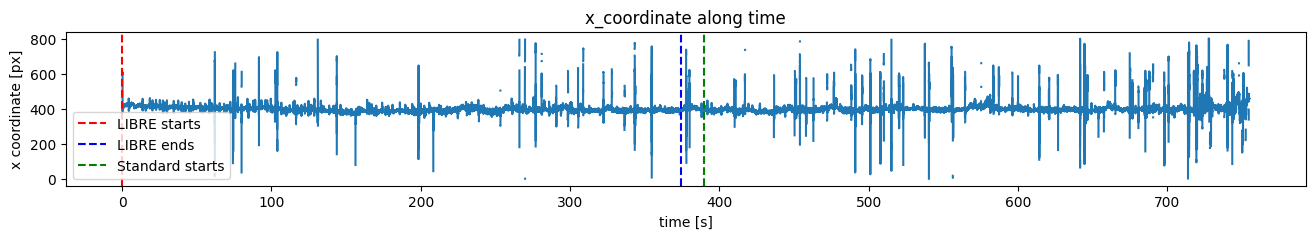

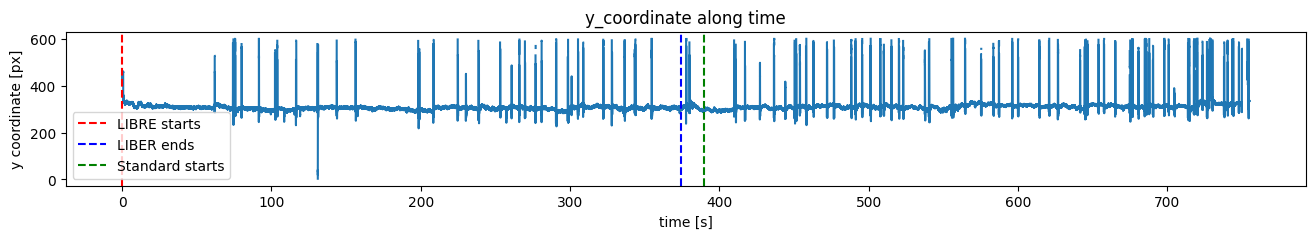

In [130]:
start_margin = int(0.0*metadata['SamplingFrequency'])
if mode == 'T1':
    print(f'mode: {mode}')
    print(f"set start margin as {start_margin}")
    T1_LIBRE_sample = T1_LIBRE*metadata['SamplingFrequency']
    T1_GAP_sample = T1_GAP*metadata['SamplingFrequency']
    T1_VIBE = len(coor_data) - T1_LIBRE_sample - T1_GAP_sample
else:
    print(f'mode: {mode}')
    print(f"set start margin as {start_margin}")
    T2_LIBRE_sample = T2_LIBRE*metadata['SamplingFrequency']
    T2_GAP_sample = T2_GAP*metadata['SamplingFrequency']
    T2_TSE = len(coor_data) - T2_LIBRE_sample - T2_GAP_sample
    


t_axis_xy = (
    coor_data.index 
) / metadata["SamplingFrequency"]

# x coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["x_coordinate"].values,
)

if mode == 'T1':
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T1_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
else:
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T2_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T2_LIBRE_sample+start_margin+T2_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
    
plt.title("x_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("x coordinate [px]")
plt.legend()

# y coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["y_coordinate"].values,
)
if mode == "T1":
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T1_LIBRE_sample+start_margin)/ metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBER ends')
    plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
else:
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T2_LIBRE_sample+start_margin)/ metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBER ends')
    plt.axvline(x=(T2_LIBRE_sample+start_margin+T2_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
    
plt.title("y_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("y coordinate [px]")
plt.legend()

if mode == 'T1':
    coor_data_LIBRE = coor_data[start_margin:int(T1_LIBRE_sample)] 
    coor_recording_LIBRE = coor_recording[start_margin:int(T1_LIBRE_sample)] 
    coor_data_STANDARD = coor_data[int(T1_LIBRE_sample+start_margin+T1_GAP_sample):] 
    coor_recording_STANDARD = coor_recording[int(T1_LIBRE_sample+start_margin+T1_GAP_sample):] 
else:
    coor_data_LIBRE = coor_data[start_margin:int(T2_LIBRE_sample)] 
    coor_recording_LIBRE = coor_recording[start_margin:int(T2_LIBRE_sample)] 
    coor_data_STANDARD = coor_data[int(T2_LIBRE_sample+start_margin+T2_GAP_sample):] 
    coor_recording_STANDARD = coor_recording[int(T2_LIBRE_sample+start_margin+T2_GAP_sample):] 
coor_data_LIBRE_raw = copy.deepcopy(coor_data_LIBRE)
print(len(coor_data_LIBRE))
print(len(coor_data_STANDARD))

### Eliminating blinking

In [131]:
use_eliminate_blink = True

def eliminate_blink(coor_data, coor_recording, seq_name):
#     coor_data = coor_data[coor_recording.blink < 1]
#     coor_recording = coor_recording[coor_recording.blink < 1]
# Note: instead of filtering them out, I assign nan to the invalid elements
    print(f'The data will be eliminated: {len(coor_data[coor_recording.blink > 0])}')
    coor_data.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan
    coor_recording.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan
    print(f'After eliminating blinking: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording


if use_eliminate_blink:
    coor_data_LIBRE,  coor_recording_LIBRE = eliminate_blink(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
# coor_data_STANDARD,  coor_recording_STANDARD = eliminate_blink(coor_data_STANDARD, 
#                                                                coor_recording_STANDARD, 'STANDARD')
plot_heatmap = False
if plot_heatmap:
    import plot
    plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                                 title='LIBRE: The gaze from the beginning to the end')
    plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                                 title='STANDARD: The gaze from the beginning to the end')

The data will be eliminated: 9513
After eliminating blinking: 
len of coor_data_LIBRE 374558       should be equal to len of coor_recording 374558


/var/folders/x4/yl1kbpks5sxc3345y3ttk6gm0000gn/T/ipykernel_39389/395681592.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coor_data.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan


In [132]:
# coor_data_LIBRE[coor_recording_LIBRE.blink > 0]

### Preserving fixation

In [136]:
use_preserve_fixation = True

def preserve_fixation(coor_data, coor_recording, seq_name):
#     coor_data = coor_data[coor_recording.fixation > 0]
#     coor_recording = coor_recording[coor_recording.fixation > 0]
    print(f'The data will be eliminated: {len(coor_data[coor_recording.fixation < 1])}')
    coor_data.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan
    coor_recording.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan

    print(f'After preserving fixation: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording


if use_preserve_fixation:
    coor_data_LIBRE,  coor_recording_LIBRE = preserve_fixation(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
    # coor_data_STANDARD,  coor_recording_STANDARD = preserve_fixation(coor_data_STANDARD, 
    #                                                                coor_recording_STANDARD, 'STANDARD')
plot_heatmap = False
if plot_heatmap:
    import plot
    plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                                 title='LIBRE: The gaze from the beginning to the end')
    plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                                 title='STANDARD: The gaze from the beginning to the end')

The data will be eliminated: 21482
After preserving fixation: 
len of coor_data_LIBRE 374558       should be equal to len of coor_recording 374558


/var/folders/x4/yl1kbpks5sxc3345y3ttk6gm0000gn/T/ipykernel_39389/1236913166.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coor_data.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan


### Plot the gazing dots

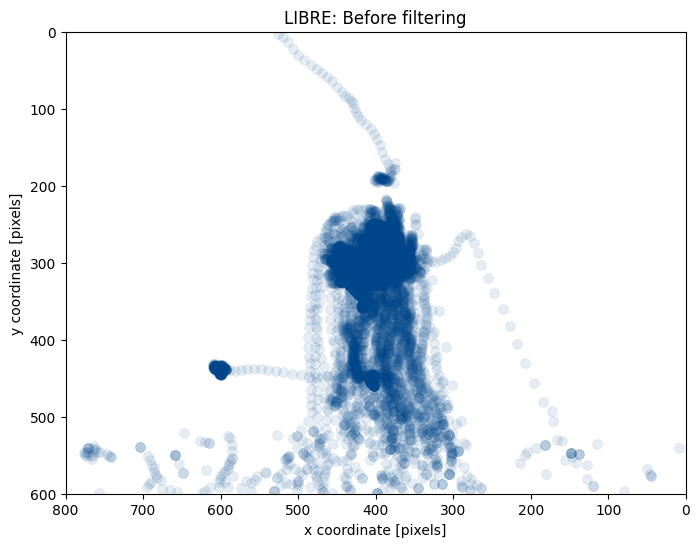

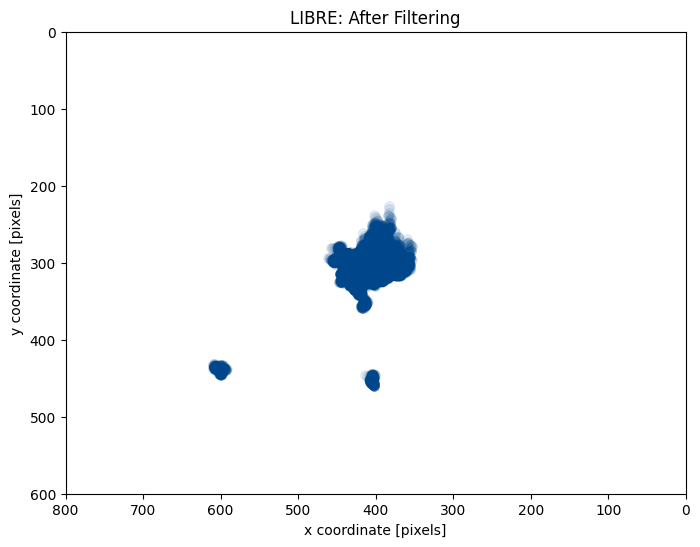

In [145]:
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE_raw['x_coordinate']
Y_coord = coor_data_LIBRE_raw['y_coordinate']
fig, ax= plt.subplots(figsize=(8, 6))
# Plot the data, flipping X coordinates and using dots as markers
plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('LIBRE: Before filtering')
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# ============================================================
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE['x_coordinate']
Y_coord = coor_data_LIBRE['y_coordinate']
fig, ax= plt.subplots(figsize=(8, 6))
# Plot the data, flipping X coordinates and using dots as markers
plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('LIBRE: After Filtering')
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# ============================================================



plot the distribution along x and y axis separately

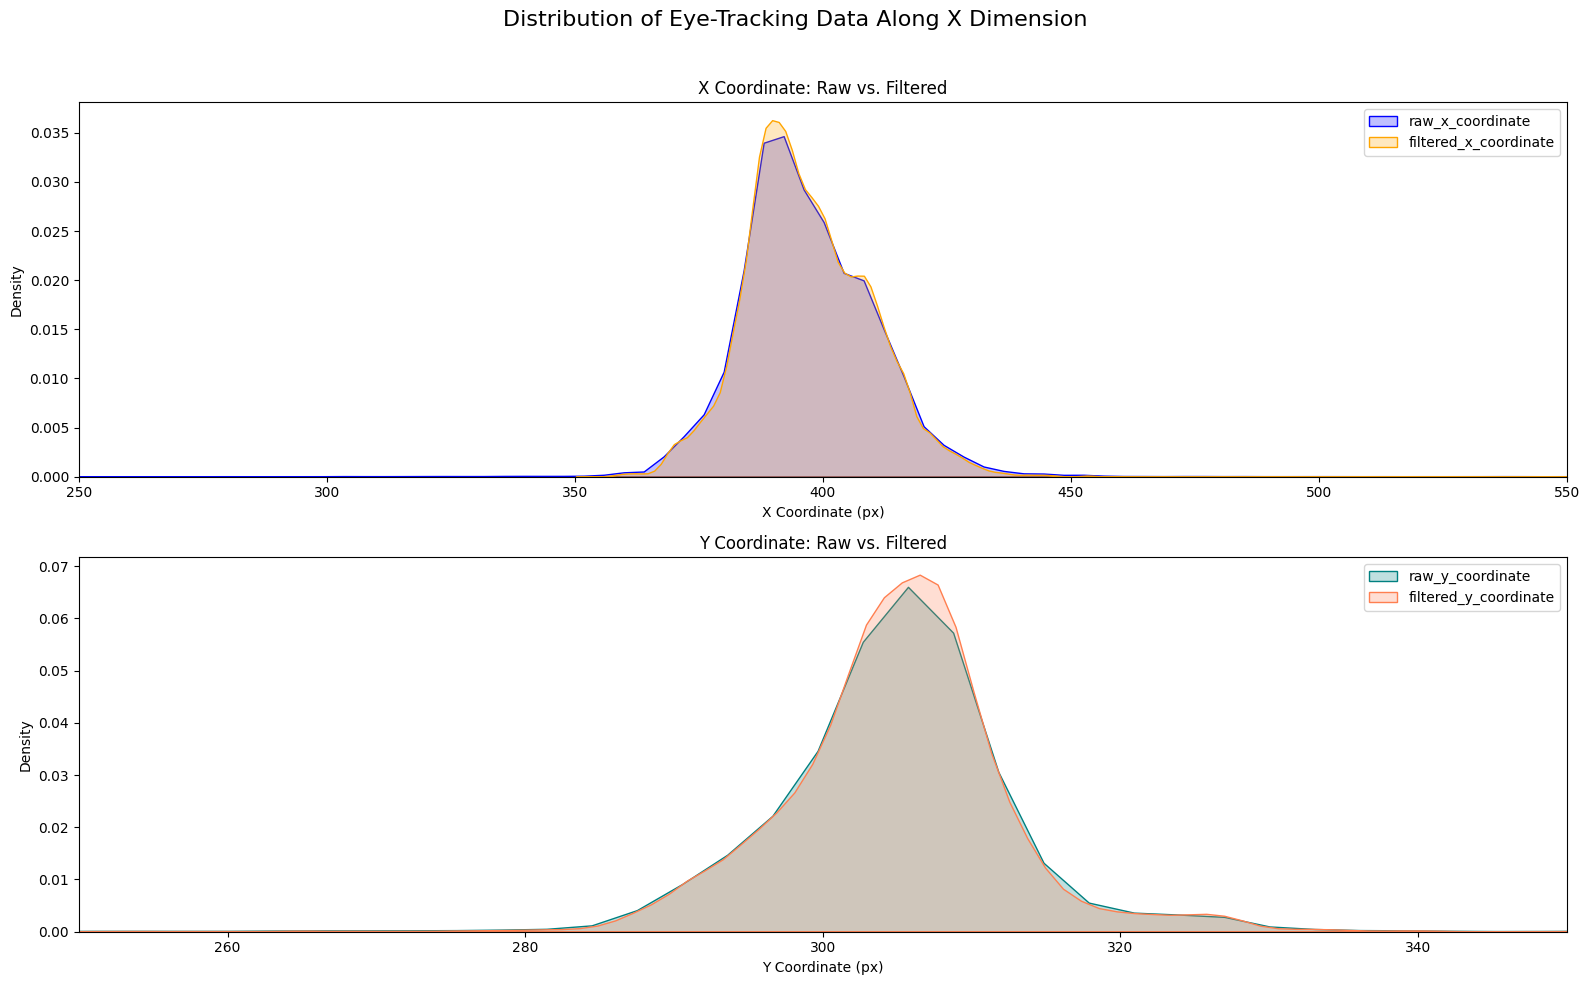

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot KDE for eye1_x_coordinate
sns.kdeplot(coor_data_LIBRE_raw['x_coordinate'].dropna(), ax=axes[0], color='blue', fill=True, label='raw_x_coordinate')
sns.kdeplot(coor_data_LIBRE['x_coordinate'].dropna(), ax=axes[0], color='orange', fill=True, label='filtered_x_coordinate')
axes[0].set_title("X Coordinate: Raw vs. Filtered")
axes[0].set_xlabel("X Coordinate (px)")
axes[0].set_ylabel("Density")
axes[0].set_xlim((250,550))
axes[0].legend()

# Plot KDE for y coordinate
sns.kdeplot(coor_data_LIBRE_raw["y_coordinate"].dropna(), ax=axes[1], color='teal', fill=True, label='raw_y_coordinate')
sns.kdeplot(coor_data_LIBRE["y_coordinate"].dropna(), ax=axes[1], color='coral', fill=True, label='filtered_y_coordinate')
axes[1].set_title("Y Coordinate: Raw vs. Filtered")
axes[1].set_xlabel("Y Coordinate (px)")
axes[1].set_ylabel("Density")
axes[1].set_xlim((250,350))
axes[1].legend()

# Add a common title
fig.suptitle("Distribution of Eye-Tracking Data Along X Dimension", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Visual Angle

#### Method 2

In [194]:
def cal_mask(coor_data, stand_x_upper=0.15, stand_x_lower=-0.15, stand_y_upper=0.15, stand_y_lower=-0.15):
    Disp_dict = {}
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    print(f'X_coord {X_coord}')
    print(f'Y_coord {Y_coord}')
    print('After cleaning nan, eminating data affected by blinking,\
            and preserving the fixation ')
    print(f'The length of X coordinate data: {len(X_coord)}')
    print(f'The length of Y coordinate data: {len(Y_coord)}')
  
    Disp_mm_eye_x =  X_coord
    Disp_mm_eye_y =  Y_coord
    
    Disp_dict['Disp_mm_eye'] = (Disp_mm_eye_x, Disp_mm_eye_y)

    med_x = np.nanmedian(Disp_mm_eye_x)
    med_y = np.nanmedian(Disp_mm_eye_y)

    Disp_dict['Disp_med'] = (med_x, med_y)

    # Subtract median
    Disp_mm_eye_x_minus_mx = Disp_mm_eye_x - med_x
    Disp_mm_eye_y_minus_my = Disp_mm_eye_y - med_y
    Disp_dict['Disp_mm_eye_minus_med'] = (Disp_mm_eye_x_minus_mx, Disp_mm_eye_y_minus_my)
    
    Ms_to_be_discarded_x_mask = (
            np.logical_or(
                Disp_mm_eye_x_minus_mx > stand_x_upper,
                Disp_mm_eye_x_minus_mx < stand_x_lower
            ) | np.isnan(Disp_mm_eye_x_minus_mx)
        )
    Ms_to_be_discarded_y_mask = (
            np.logical_or(
                Disp_mm_eye_y_minus_my > stand_y_upper,
                Disp_mm_eye_y_minus_my < stand_y_lower
            ) | np.isnan(Disp_mm_eye_y_minus_my)
        )
    Disp_dict['Ms_to_be_discarded_mask'] = (Ms_to_be_discarded_x_mask, Ms_to_be_discarded_y_mask)
    Disp_dict['stand_xy'] = (stand_x_upper, stand_x_lower, stand_y_upper, stand_y_lower)
    return Disp_dict


def cal_stats(coor_data):
    stats_dict = {}
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    
    stats_dict['x_mean'] = np.nanmean(X_coord)
    stats_dict['x_median'] = np.nanmedian(X_coord)      # Median, ignoring NaNs
    stats_dict['x_std'] = np.nanstd(X_coord)        # Standard deviation
    stats_dict['x_min'] = np.nanmin(X_coord)      # Minimum value
    stats_dict['x_max'] = np.nanmax(X_coord)      # Maximum value
    # Calculate 25th, 50th (median), and 75th percentiles while ignoring NaN values
    stats_dict['x_q25'] = np.nanpercentile(X_coord, 25)  # 25th percentile
    stats_dict['x_q75'] = np.nanpercentile(X_coord, 75)  # 75th percentile

    stats_dict['y_mean'] = np.nanmean(Y_coord)
    stats_dict['y_median'] = np.nanmedian(Y_coord)      # Median, ignoring NaNs
    stats_dict['y_std'] = np.nanstd(Y_coord)        # Standard deviation
    stats_dict['y_min'] = np.nanmin(Y_coord)      # Minimum value
    stats_dict['y_max'] = np.nanmax(Y_coord)      # Maximum value
    stats_dict['y_q25'] = np.nanpercentile(Y_coord, 25)  # 25th percentile
    stats_dict['y_q75'] = np.nanpercentile(Y_coord, 75)  # 75th percentile

    return stats_dict

    

In [237]:
def plot_x_y_coord(Disp_dict, metadata, duration=None, start_sample=0, seq_name=None):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=24, weight='bold')
    
    Disp_mm_eye_x = Disp_dict['Disp_mm_eye'][0]
    Disp_mm_eye_y = Disp_dict['Disp_mm_eye'][1]
    Disp_mm_eye_x_minus_mx = Disp_dict['Disp_mm_eye_minus_med'][0]
    Disp_mm_eye_y_minus_my = Disp_dict['Disp_mm_eye_minus_med'][1]
    Ms_to_be_discarded_x_mask = Disp_dict['Ms_to_be_discarded_mask'][0]
    Ms_to_be_discarded_y_mask = Disp_dict['Ms_to_be_discarded_mask'][1]
    
    if duration == None:
        end_sample = len(Disp_mm_eye_x)
    else:    
        end_sample = duration*metadata["SamplingFrequency"]

    t_axis_xy = np.arange(start_sample, end_sample, 1)/metadata["SamplingFrequency"]

    # Horizontal direction!!!!!
    fig, ax= plt.subplots(figsize=(8, 4))
    
    # ax.plot(
    #     t_axis_xy,
    #     Disp_mm_eye_x[start_sample:end_sample],
    #     marker='o', color='blue',
    #     label="Horizontal displacement in mm"
    # )
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_x_minus_mx[start_sample:end_sample],
        marker='*', color='#FFBF00',
        label='Horizontal displacement in mm - med x'
    )

    if len(Ms_to_be_discarded_x_mask) != 0:
        ax.plot(
            t_axis_xy,
            Disp_mm_eye_x_minus_mx[start_sample:end_sample] * Ms_to_be_discarded_x_mask[start_sample:end_sample],
            marker='^', color='#008080',
            label= 'MS to be discarded'
        )
    ax.axhline(y=Disp_dict['stand_xy'][0], color='r', linestyle='--', label='upper boundary')
    ax.axhline(y=Disp_dict['stand_xy'][1], color='r', linestyle='--', label='lower boundary')
    ax.legend()
    ax.set_title(seq_name, fontproperties=title_font)
    plt.tight_layout()

    # Vertical direction!!!!!
    fig, ax= plt.subplots(figsize=(8, 4))
    # ax.plot(
    #     t_axis_xy,
    #     Disp_mm_eye_y[start_sample:end_sample],
    #     marker='o', color='blue',
    #     label="Vertical displacement in mm"
    # )
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_y_minus_my[start_sample:end_sample],
        marker='*', color='#FFBF00',
        label='Vertical displacement in mm - med x'
    )

    if len(Ms_to_be_discarded_y_mask) != 0:
        ax.plot(
            t_axis_xy,
            Disp_mm_eye_y_minus_my[start_sample:end_sample] * Ms_to_be_discarded_y_mask[start_sample:end_sample],
            marker='^', color='#008080',
            label= 'MS to be discarded'
        )

    ax.axhline(y=Disp_dict['stand_xy'][2], color='r', linestyle='--', label='upper boundary')
    ax.axhline(y=Disp_dict['stand_xy'][3], color='r', linestyle='--', label='lower boundary')
    ax.legend()
    ax.set_title(seq_name, fontproperties=title_font)
    plt.tight_layout()



In [238]:
def filter_XY_coord(coor_data, Disp_dict, seq_name=None):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=20, weight='bold')
    axis_font = FontProperties(family='Times New Roman', size=20)
#     x y coordinate accordingly
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    Ms_to_be_discarded_x_mask = Disp_dict['Ms_to_be_discarded_mask'][0]
    Ms_to_be_discarded_y_mask = Disp_dict['Ms_to_be_discarded_mask'][1]
    
    Combined_mask = ~(Ms_to_be_discarded_x_mask|Ms_to_be_discarded_y_mask)
   
    filtered_X_coord = X_coord * Combined_mask
    filtered_Y_coord = Y_coord * Combined_mask

    zero_mask = (filtered_X_coord == 0) & (filtered_Y_coord == 0)
    filtered_X_coord[zero_mask] = np.nan
    filtered_Y_coord[zero_mask] = np.nan
    
    Discard_mask = np.where(np.isnan(filtered_X_coord) | np.isnan(filtered_Y_coord), 1, 0)

    # Example data (replace with your actual data)
    fig, ax= plt.subplots(figsize=(8, 6))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.plot(filtered_X_coord, filtered_Y_coord, '.', color='#00468b',markersize=15)
    plt.xlim(0, 800)
    plt.ylim((0, 600))
    # Set plot title
    if seq_name is not None:
        plt.title(f'Fixation skills evaluation after screening: {seq_name}', fontproperties=title_font)
    else:     
        plt.title('Fixation skills evaluation after screening', fontproperties=title_font)

    # Reverse the direction of the Y-axis
    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(axis_font)

    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(axis_font)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    coor_data["x_coordinate"] = filtered_X_coord
    coor_data["y_coordinate"] = filtered_Y_coord
    
    return coor_data, Combined_mask, Discard_mask
    




In [245]:
coor_data_LIBRE_1 = copy.deepcopy(coor_data_LIBRE)
stats_dict = cal_stats(coor_data_LIBRE_1)
print(stats_dict)


{'x_mean': 397.06954140148815, 'x_median': 395.5, 'x_std': 13.955737401446955, 'x_min': 353.3999938964844, 'x_max': 609.7999877929688, 'x_q25': 388.2999877929688, 'x_q75': 405.2999877929688, 'y_mean': 305.2710657401416, 'y_median': 305.29998779296875, 'y_std': 9.855362153300605, 'y_min': 225.8000030517578, 'y_max': 460.7000122070313, 'y_q25': 301.0, 'y_q75': 309.0}


stand_x_upper-9.799987792968807 stand_x_lower--7.200012207031193 stand_y_upper-3.70001220703125 stand_y_lower--4.29998779296875
X_coord [        nan         nan         nan ... 398.8999939 398.5
 398.6000061]
Y_coord [         nan          nan          nan ... 302.1000061  301.79998779
 300.1000061 ]
After cleaning nan, eminating data affected by blinking,            and preserving the fixation 
The length of X coordinate data: 374558
The length of Y coordinate data: 374558


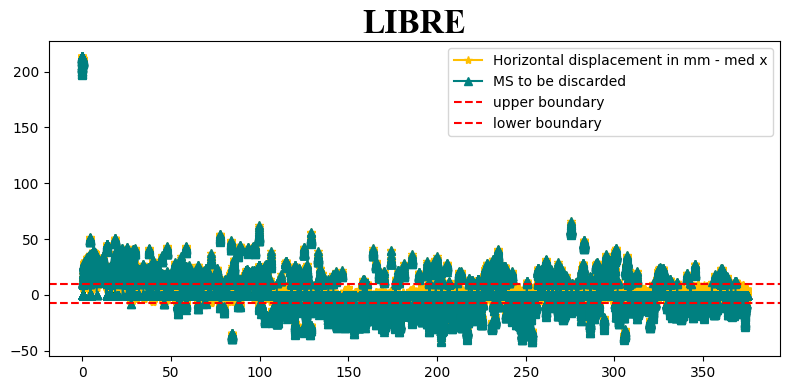

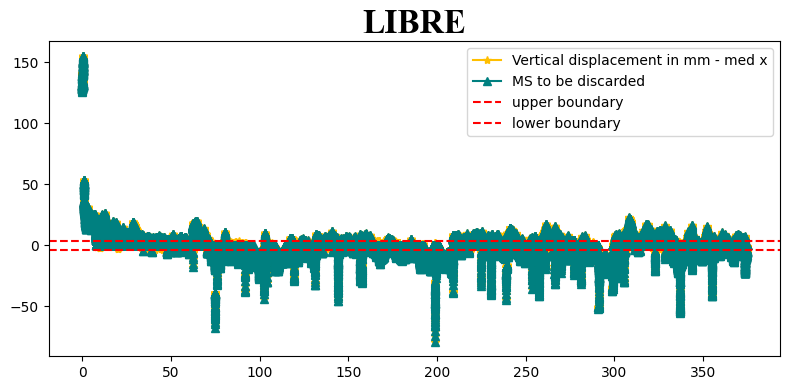

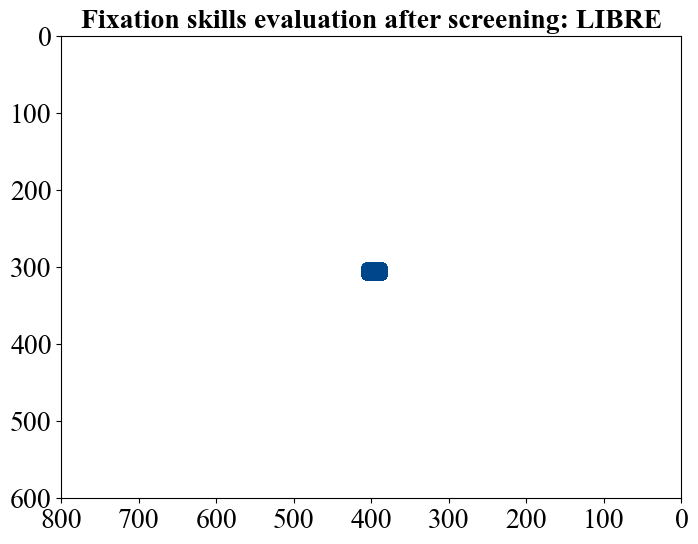

In [246]:
# You can play with the upper and lower boundary to filter the data as you need
stand_x_upper=stats_dict['x_q75']-stats_dict['x_median']
stand_x_lower=stats_dict['x_q25']-stats_dict['x_median']
stand_y_upper=stats_dict['y_q75']-stats_dict['y_median']
stand_y_lower=stats_dict['y_q25']-stats_dict['y_median']
print(f'stand_x_upper-{stand_x_upper} stand_x_lower-{stand_x_lower} stand_y_upper-{stand_y_upper} stand_y_lower-{stand_y_lower}')

Disp_dict_LIBRE = cal_mask(coor_data_LIBRE_1, stand_x_upper, stand_x_lower, 
                           stand_y_upper, stand_y_lower)
plot_x_y_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
filtered_coor_data_LIBRE, Preserve_mask, Discard_mask = filter_XY_coord(coor_data_LIBRE_1, Disp_dict_LIBRE, 'LIBRE')

In [241]:
coor_data_LIBRE_1 = copy.deepcopy(coor_data_LIBRE)
stats_dict = cal_stats(coor_data_LIBRE_1)
print(stats_dict)

{'x_mean': 397.06954140148815, 'x_median': 395.5, 'x_std': 13.955737401446955, 'x_min': 353.3999938964844, 'x_max': 609.7999877929688, 'x_q25': 388.2999877929688, 'x_q75': 405.2999877929688, 'y_mean': 305.2710657401416, 'y_median': 305.29998779296875, 'y_std': 9.855362153300605, 'y_min': 225.8000030517578, 'y_max': 460.7000122070313, 'y_q25': 301.0, 'y_q75': 309.0}


stand_x_upper-40 stand_x_lower--40 stand_y_upper-40 stand_y_lower--40
X_coord [        nan         nan         nan ... 398.8999939 398.5
 398.6000061]
Y_coord [         nan          nan          nan ... 302.1000061  301.79998779
 300.1000061 ]
After cleaning nan, eminating data affected by blinking,            and preserving the fixation 
The length of X coordinate data: 374558
The length of Y coordinate data: 374558


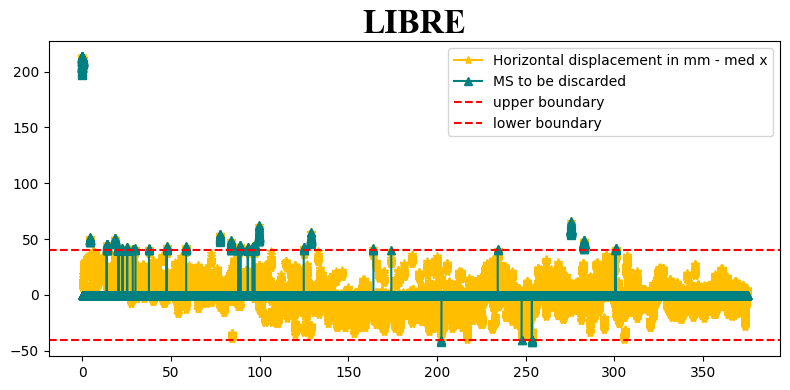

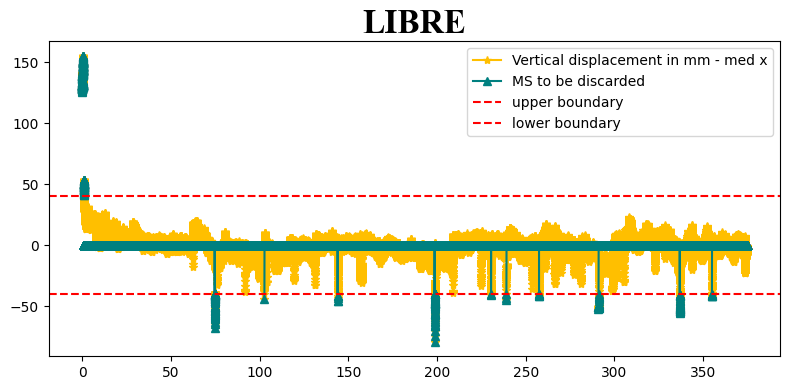

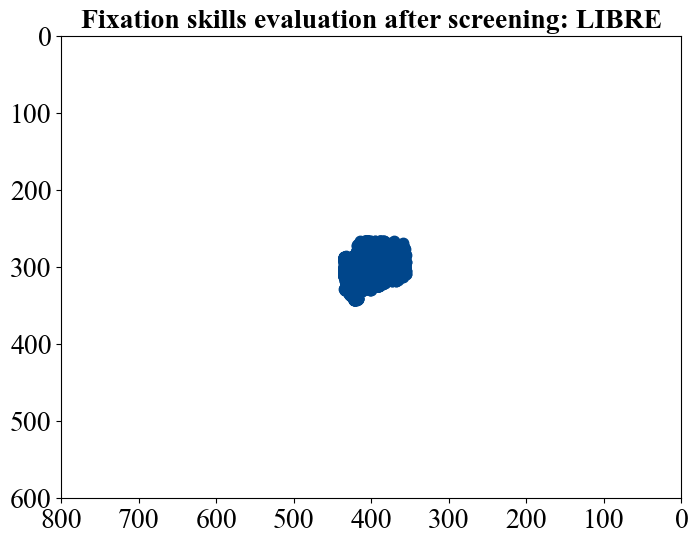

In [242]:
# You can play with the upper and lower boundary to filter the data as you need
stand_x_upper=40
stand_x_lower=-40
stand_y_upper=40
stand_y_lower=-40
print(f'stand_x_upper-{stand_x_upper} stand_x_lower-{stand_x_lower} stand_y_upper-{stand_y_upper} stand_y_lower-{stand_y_lower}')

Disp_dict_LIBRE = cal_mask(coor_data_LIBRE_1, stand_x_upper, stand_x_lower, 
                           stand_y_upper, stand_y_lower)
plot_x_y_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
filtered_coor_data_LIBRE, Preserve_mask, Discard_mask = filter_XY_coord(coor_data_LIBRE_1, Disp_dict_LIBRE, 'LIBRE')

if same 0         False
1         False
2         False
3         False
4         False
          ...  
374553    False
374554    False
374555     True
374556     True
374557    False
Name: x_coordinate, Length: 374558, dtype: bool


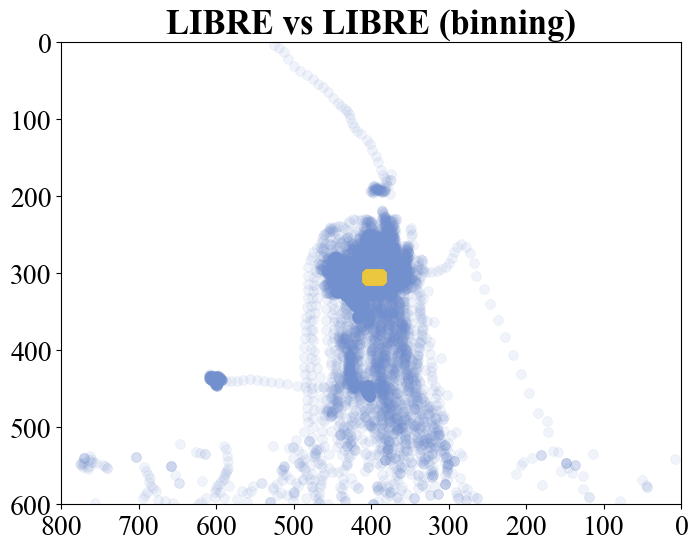

In [247]:
def visualization_func(fig_title, filtered_coor_data_LIBRE):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=25, weight='bold')
    axis_font = FontProperties(family='Times New Roman', size=20)
    
    fig, ax= plt.subplots(figsize=(8, 6))
    plt.title(fig_title, fontproperties=title_font)
#     -----------------------------------------------------------------------
#     # Plot the data, flipping X coordinates and using dots as markers
#     X_coord = coor_data_STANDARD['x_coordinate']
#     Y_coord = coor_data_STANDARD['y_coordinate']
#     plt.plot(X_coord, Y_coord, '.', color='#ADD8E6', markersize=15, label='Standard')
#     -----------------------------------------------------------------------
    coor_data_LIBRE_vis = copy.deepcopy(coor_data_LIBRE)
    X_coord_1 = coor_data_LIBRE_raw['x_coordinate']
    Y_coord_1 = coor_data_LIBRE_raw['y_coordinate']

    # plt.plot(X_coord_1, Y_coord_1, '.', color='#728FCE', markersize=15, label='LIBRE w.o. binning')
    plt.scatter(X_coord_1, Y_coord_1, s=50, c='#728FCE', alpha=0.1, edgecolors='#728FCE', linewidth=0.5)
    
#     -----------------------------------------------------------------------
    X_coord = filtered_coor_data_LIBRE['x_coordinate']
    Y_coord = filtered_coor_data_LIBRE['y_coordinate']
    print(F"if same {X_coord_1 == X_coord}")
    # plt.plot(X_coord, Y_coord, '.', color='#f4d03f', markersize=15, label='LIBRE binning')
    plt.scatter(X_coord, Y_coord, s=50, c='#f4d03f', alpha=0.1, edgecolors='#f4d03f', linewidth=0.5)  # Larger points
#     ----------------------------------------------------------------------------------------------
    # plt.legend(prop={'family': 'Times New Roman', 'size': 10})
    
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
#     plt.title(fig_title, fontproperties=title_font)
    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(axis_font)

    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(axis_font)
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

    
# Visualization of filtered coor data LIBRE
visualization_func(fig_title='LIBRE vs LIBRE (binning)', 
                   filtered_coor_data_LIBRE=filtered_coor_data_LIBRE)



## Investigate eye movement events


In [333]:
# Specify the subject and modality you want to inspect

T_idx = 1
recording_list = []
for subject_idx in range(1,5):
    print(f'Load recording for subject {subject_idx}...')
    if T_idx == 1:
        mode = 'T1'
    else:
        mode = 'T2'
    
    
    BIDS_PATH = Path("./data/")  # file within a subdirectory
    FILE_NAME = f"sub00{subject_idx}_T{T_idx}"    
        
    
    tsv_name = f"{FILE_NAME}.tsv.gz"
    
    recording_file = BIDS_PATH / tsv_name
    print(f'recording_file: {recording_file}')
    
    recording = pd.read_csv(
        recording_file,
    #     sep=r"\s+",
        sep="\t",
        na_values="n/a",
    )
    
    # Duration setting according to the MRI sequence info
    if  subject_idx == 1:
        T1_LIBRE = 374.558
        T2_LIBRE = 650.185
    elif subject_idx == 2:
        T1_LIBRE = 374.380
        T2_LIBRE = 650.185
    elif subject_idx == 3:
        T1_LIBRE = 334.237
        T2_LIBRE = 650.1925 
    else:
        T1_LIBRE = 374.565
        T2_LIBRE = 650.1875

    if T_idx == 1:
        print(f"The length of T1_LIBRE Subject{subject_idx} should be: {T1_LIBRE}")
    else:
        print(f"The length of T2_LIBRE Subject{subject_idx} should be: {T2_LIBRE}")

    coor_recording = recording
    start_margin = int(0.0)
    if mode == 'T1':
        print(f'mode: {mode}')
        T1_LIBRE_sample = T1_LIBRE*metadata['SamplingFrequency']
        T1_GAP_sample = T1_GAP*metadata['SamplingFrequency']
        T1_VIBE = len(recording) - T1_LIBRE_sample - T1_GAP_sample
    else:
        print(f'mode: {mode}')
        T2_LIBRE_sample = T2_LIBRE*metadata['SamplingFrequency']
        T2_GAP_sample = T2_GAP*metadata['SamplingFrequency']
        T2_TSE = len(recording) - T2_LIBRE_sample - T2_GAP_sample
        
    if mode == 'T1':
        coor_recording_LIBRE = coor_recording[start_margin:int(T1_LIBRE_sample)]   
    else:
        coor_recording_LIBRE = coor_recording[start_margin:int(T2_LIBRE_sample)] 
    coor_recording_LIBRE = coor_recording_LIBRE.rename(columns={'eye1_saccade': 'saccade'})
    coor_recording_LIBRE = coor_recording_LIBRE.rename(columns={'eye1_fixation': 'fixation'})
    coor_recording_LIBRE = coor_recording_LIBRE.rename(columns={'eye1_blink': 'blink'})
    recording_list.append(coor_recording_LIBRE)

Load recording for subject 1...
recording_file: data/sub001_T1.tsv.gz
The length of T1_LIBRE Subject1 should be: 374.558
mode: T1
Load recording for subject 2...
recording_file: data/sub002_T1.tsv.gz
The length of T1_LIBRE Subject2 should be: 374.38
mode: T1
Load recording for subject 3...
recording_file: data/sub003_T1.tsv.gz
The length of T1_LIBRE Subject3 should be: 334.237
mode: T1
Load recording for subject 4...
recording_file: data/sub004_T1.tsv.gz
The length of T1_LIBRE Subject4 should be: 374.565
mode: T1


In [334]:
len(recording_list)

4

In [335]:
# Identify start and end indices of each event
def identify_start_end_event(df, events):
    event_dict = {}
    for event in events:
        event_change = event+'_change'
        
        event_starts = df.index[df[event_change] == 1].tolist()
        event_ends = df.index[df[event_change] == -1].tolist()
        
        # If the last row is part of a event, add it as an end
        if df[event].iloc[-1] == 1:
            event_ends.append(df.index[-1])
        
        # Calculate number of events
        num_events = len(event_starts)
        
        # Calculate duration for each event
        event_durations = []
        for start, end in zip(event_starts, event_ends):
            # Duration in milliseconds or based on the timestamp difference
            duration = end - start + 1  # If in milliseconds
            # If you have a timestamp column (e.g., in ms), you could calculate it as:
            # duration = df['timestamp'].iloc[end] - df['timestamp'].iloc[start]
            event_durations.append(duration)
        
        # Display results
        num_event_str = 'num_'+event
        event_dict[num_event_str] = num_events
        event_duration_str = event+'_durations'
        event_dict[event_duration_str] = event_durations

    return event_dict
  


In [336]:
df

,Unnamed: 0,eye1_x_coordinate,eye1_y_coordinate,eye1_pupil_size,eye1_pupil_x_coordinate,eye1_pupil_y_coordinate,eye1_href_x_coordinate,eye1_href_y_coordinate,fast_raw_x_velocity,screen_ppdeg_x_coordinate,...,timestamp,eye1_fixation,eye1_saccade,eye1_blink,saccade_shift,saccade_change,fixation_shift,fixation_change,blink_shift,blink_change
0,0,599.799988,440.299988,2721.0,1126.0,-4793.0,1972.0,1384.0,4.591214e-41,27.1,...,1084634,0,0,0,0,0,0,0,0,0
1,1,600.000000,441.299988,2718.0,1129.0,-4782.0,1974.0,1394.0,4.591214e-41,27.1,...,1084635,0,0,0,0,0,0,0,0,0
2,2,600.700012,442.399994,2716.0,1138.0,-4769.0,1981.0,1405.0,4.591214e-41,27.1,...,1084636,0,0,0,0,0,0,0,0,0
3,3,601.400024,442.700012,2709.0,1147.0,-4766.0,1988.0,1408.0,4.591214e-41,27.1,...,1084637,0,0,0,0,0,0,0,0,0
4,4,601.799988,443.000000,2704.0,1152.0,-4762.0,1991.0,1411.0,4.591214e-41,27.1,...,1084638,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374553,374553,398.799988,299.799988,1595.0,-1303.0,-6368.0,-10.0,-1.0,-6.355000e+03,26.5,...,1459187,1,0,0,0,0,1,0,0,0
374554,374554,399.100006,300.899994,1597.0,-1300.0,-6355.0,-8.0,9.0,-6.355000e+03,26.5,...,1459188,1,0,0,0,0,1,0,0,0
374555,374555,398.899994,302.100006,1600.0,-1303.0,-6342.0,-10.0,21.0,-6.355000e+03,26.5,...,1459189,1,0,0,0,0,1,0,0,0
374556,374556,398.500000,301.799988,1603.0,-1308.0,-6346.0,-14.0,17.0,-6.355000e+03,26.5,...,1459190,1,0,0,0,0,1,0,0,0


In [339]:
events = ['saccade', 'fixation', 'blink']
subject_event_dict = []
for idx in range(4):
    df = copy.deepcopy(recording_list[idx])
    # Detect the start and end of each saccade
    df['saccade_shift'] = df['saccade'].shift(1, fill_value=0)
    df['saccade_change'] = df['saccade'] - df['saccade_shift']
    
    # Detect the start and end of each fixation
    df['fixation_shift'] = df['fixation'].shift(1, fill_value=0)
    df['fixation_change'] = df['fixation'] - df['fixation_shift']
    
    # Detect the start and end of each blink
    df['blink_shift'] = df['blink'].shift(1, fill_value=0)
    df['blink_change'] = df['blink'] - df['blink_shift']

    event_dict = identify_start_end_event(df, events)
    subject_event_dict.append(event_dict)

In [369]:
def cal_event_stat(event_duration):
    
    event_stat_dict={}
    event_stat_dict['mean_duration'] = np.mean(event_duration)
    event_stat_dict['median_duration'] = np.median(event_duration)
    event_stat_dict['std_duration'] = np.std(event_duration)
    event_stat_dict['min_duration'] = np.min(event_duration)
    event_stat_dict['max_duration'] = np.max(event_duration)
    event_stat_dict['total_duration'] = sum(event_duration)
    event_stat_dict['times'] = len(event_duration)
    
    return event_stat_dict
    
def voilinplot(subject_event_dict, event,color='skyblue'):
    sub_num = len(subject_event_dict)
    event_duration_list=[]
    for idx in range(sub_num):
        event_durations_str = f'{event}_durations'
        event_duration_list.append(subject_event_dict[idx][event_durations_str])
        
    df = pd.DataFrame({
        'Duration': [duration for sublist in event_duration_list for duration in sublist],
        'Subject': [f'Subject {i+1}' for i, sublist in enumerate(event_duration_list) for _ in sublist]
    })
   
    plt.figure(figsize=(6, 5))
    sns.violinplot(data=df, x='Subject', y='Duration', color=color)
    plt.title(f"Violin Plot of {event} Durations Across Subjects")
    plt.ylabel("Duration (ms)")
    plt.xlabel("Subject")
    plt.show()

In [388]:
subject_blink_stat = []
subject_saccade_stat = []
subject_fixation_stat = []
for idx in range(4):
    event_dict = subject_event_dict[idx]
    
    blink_stat = cal_event_stat(event_dict['blink_durations'])
    subject_blink_stat.append(blink_stat)
    
    saccade_stat = cal_event_stat(event_dict['saccade_durations'])
    subject_saccade_stat.append(saccade_stat)
    
    fixation_stat = cal_event_stat(event_dict['fixation_durations'])
    subject_fixation_stat.append(fixation_stat)

In [390]:
subject_fixation_stat

[{'mean_duration': 485.3278463648834,
  'median_duration': 247.0,
  'std_duration': 623.9966482850247,
  'min_duration': 22,
  'max_duration': 4157,
  'total_duration': 353804,
  'times': 729},
 {'mean_duration': 672.0169811320754,
  'median_duration': 491.5,
  'std_duration': 594.362456671281,
  'min_duration': 17,
  'max_duration': 5003,
  'total_duration': 356169,
  'times': 530},
 {'mean_duration': 417.9804195804196,
  'median_duration': 246.0,
  'std_duration': 466.94418247439074,
  'min_duration': 24,
  'max_duration': 3348,
  'total_duration': 298856,
  'times': 715},
 {'mean_duration': 128.8170276325616,
  'median_duration': 92.0,
  'std_duration': 117.27843003164334,
  'min_duration': 9,
  'max_duration': 1012,
  'total_duration': 172486,
  'times': 1339}]

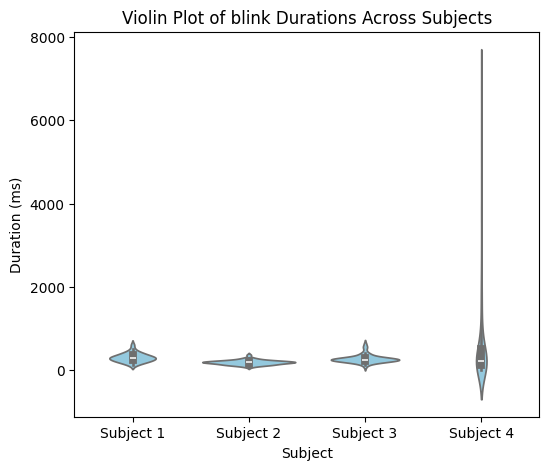

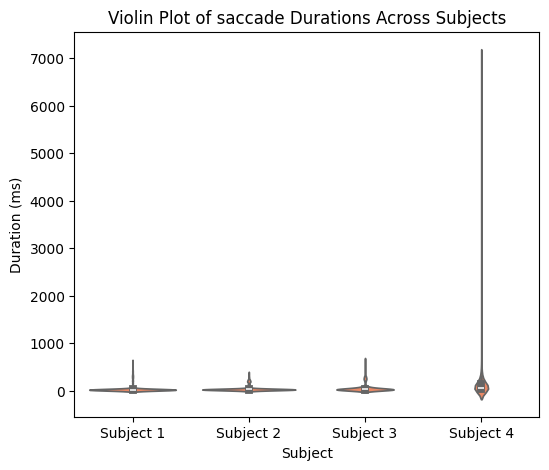

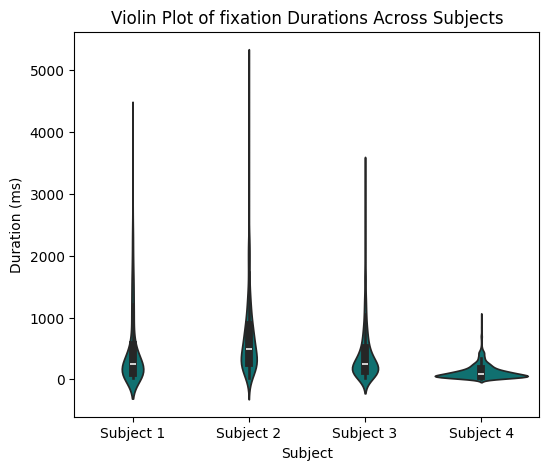

In [384]:
voilinplot(subject_event_dict, event='blink', color='skyblue')
voilinplot(subject_event_dict, event='saccade',color='coral')
voilinplot(subject_event_dict, event='fixation',color='teal')

In [379]:
def mann_whitney_u_stats(subject_event_dict, event):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from scipy.stats import mannwhitneyu
    sub_num = len(subject_event_dict)
    event_duration_list=[]
    for idx in range(sub_num):
        event_durations_str = f'{event}_durations'
        event_duration_list.append(subject_event_dict[idx][event_durations_str])
        
    # Prepare data for Seaborn
    df = pd.DataFrame({
        'Duration': [duration for sublist in event_duration_list for duration in sublist],
        'Subject': [f'subjects {i+1}' for i, sublist in enumerate(event_duration_list) for _ in sublist]
    })

    print(f"Pairwise Mann-Whitney U test results for {event} durations:")
    for i in range(sub_num):
        for j in range(i + 1, sub_num):
            stat, p_value = mannwhitneyu(event_duration_list[i], event_duration_list[j], alternative='two-sided')
            print(f"Comparison between {f'subjects {i+1}'} and {f'subjects {j+1}'}: U = {stat}, p = {p_value:.4f}")




In [385]:
mann_whitney_u_stats(subject_event_dict,'saccade')

Pairwise Mann-Whitney U test results for saccade durations:
Comparison between subjects 1 and subjects 2: U = 126157.0, p = 0.0000
Comparison between subjects 1 and subjects 3: U = 162432.0, p = 0.0000
Comparison between subjects 1 and subjects 4: U = 154110.5, p = 0.0000
Comparison between subjects 2 and subjects 3: U = 165390.0, p = 0.0002
Comparison between subjects 2 and subjects 4: U = 158977.5, p = 0.0000
Comparison between subjects 3 and subjects 4: U = 267041.5, p = 0.0000
